# Histogram equalization

**Author: Uzhva Denis Romanovich**

**Lecturer: Soloviev Igor Pavlovich**

## Histogram of an image and global equalization
### Theory

A histogram of an image is a function $h(r_k) = n_k$, which returns the number $n_k$ of pixels of the *k*th intensity value $r_k$. 
In practice, a normalized variant of such a function is usually considered: $p(r_k) = n_k/HW$, where $H$ and $W$ are image height and width in pixels correspondingly. 
Being normalized as shown, the function $p(r_k)$ becomes, by definition, a probability distribution function $p_r(r_k)$ of a pixel $r$ to have an intensity level $r_k$.

By examining a histogram of an image, one may suggest a conclusion on the balance of bright and dark pixels of the picture. 
For example, an overexposed image would have a significant bias towards high values of $r_k$ on its histogram; the same can be applied to an opposite case.
Thus, a balanced image with fine contrast is supposed to have a uniform distribution $p(r_k)$ or a close to uniform one. 

Given the above, one may transform an image to obtain a desired shape of a histogram.
Such a transformation is called *equalization*: it is basically a function $s = T(r)$ with the following properties:
1. $T(r)$ is a strictly monotonically increasing function in the interval $0 \leq r \leq L - 1$, where $L - 1$ is the maximum level of intensity of an image.
2. $0 \leq T(r) \leq L - 1$ for $0 \leq r \leq L - 1$.

A very important transformation function is the following one:
$$
\begin{equation}
s = T(r) = (L - 1) \int_0^r p_r(w)dw.
\tag{1}
\end{equation}
$$
The main property of such a function that, after this transformation is applied, the PDF $p_s(s)$ becomes uniform with height $\frac{1}{L - 1}$, independently of $p_r(r)$.
This property can be simply derived from the fact that $p_s(s) = p_r(r) | \frac{r}{s} |$, followed by direct differentiation of the equation $T(r)$. 
hich can be rewritten for the discrete case like this:
$$
\begin{equation}
s_k = T(r_k) = (L - 1) \sum_{j = 0}^k p_r(r_j) = \frac{L - 1}{HW} \sum_{j = 0}^k n_j. 
\tag{2}
\end{equation}
$$

### Code

#### A histogram maker

In [1]:
import numpy as np


def im_hist(img, normalize=True):
    Lm1 = 256
    if len(img.shape) == 3:
        channels = img.shape[-1]
        hist_arr = np.zeros((channels, Lm1))
        for rk in range(Lm1):
            where_rk = np.argwhere(img == rk)
            for ch in range(channels):
                hist_arr[ch, rk] = np.argwhere(where_rk[:, 2] == ch).size
    else:
        hist_arr = np.zeros((Lm1))
        for rk in range(Lm1):
            where_rk = np.argwhere(img == rk)
            hist_arr[rk] = where_rk.shape[0]
            
    if normalize:
        h = img.shape[0]
        w = img.shape[1]
        hist_arr /= (h * w)
        
    return hist_arr

#### A faster histogram maker

In [2]:
import numpy as np


def im_hist_np(img, normalize=True):
    Lm1 = 256
    if len(img.shape) == 3:
        channels = img.shape[-1]
        hist_arr = np.zeros((channels, Lm1), dtype=float)
        for ch in range(channels):
            hist_arr[ch, :] = np.histogram(img[:, :, ch].flatten(), bins=np.arange(Lm1 + 1))[0]
    else:
        hist_arr = np.histogram(img.flatten(), bins=np.arange(Lm1 + 1))[0].astype(float)
        
    if normalize:
        h = img.shape[0]
        w = img.shape[1]
        hist_arr /= (h * w)
        
    return hist_arr

#### $T(r)$ as defined in (2)

In [3]:
import numpy as np


def eq_uniform(img, hist_arr):
    h = img.shape[0]
    w = img.shape[1]
    Lm1 = 256
    
    img_new = np.zeros_like(img)
    
    if len(img.shape) == 3:
        for rk in range(Lm1):
            where_rk = np.argwhere(img == rk)
            where_rk_bin = img == rk
            hist_sum_k = np.sum(hist_arr[:, :rk], axis=1)
            #print(where_rk[:, 2])
            img_new[where_rk_bin] = Lm1 * hist_sum_k[where_rk[:, 2]]
    else:
        for rk in range(Lm1):
            where_rk_bin = img == rk
            hist_sum_k = np.sum(hist_arr[:rk])
            img_new[where_rk_bin] = Lm1 * hist_sum_k
            
    img_new = img_new.astype(np.uint8)
    return img_new

#### Histogram plotter

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def plot_hist(hist):
    if len(hist.shape) == 2:
        plt.figure(figsize=(16, 6))
        plt.bar(np.arange(256), hist[0], width=1., alpha=0.5, color='r')
        plt.bar(np.arange(256), hist[1], width=1., alpha=0.5, color='g')
        plt.bar(np.arange(256), hist[2], width=1., alpha=0.5, color='b')
    else:
        plt.figure(figsize=(16, 6))
        plt.bar(np.arange(256), hist, width=1., color='k')
        
    plt.xlabel('r_k')
    plt.ylabel('entries')
    plt.show()    

### Results

#### Processing + visualization

First of all, we need to load images for the further processing:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# From R. Gonzales, R. Woods "Digital Image Processing"
img_1 = Image.open('./foo.tif')
# https://dipandcvofgong.wordpress.com/2011/08/02/image-processing-multi-spectral-image-thresholding-smoothing-with-a-rotating-mask/
img_2 = Image.open('./map.jpg')

In [6]:
# represent the images as tensors
np_1 = np.array(img_1)
np_2 = np.array(img_2)
print('Picture dimensions:')
print(np_1.shape)
print(np_2.shape)

Picture dimensions:
(500, 500)
(691, 1048, 3)


Get histograms:

In [7]:
hist_1 = im_hist_np(np_1)
hist_2 = im_hist_np(np_2)

1st image and its histogram:

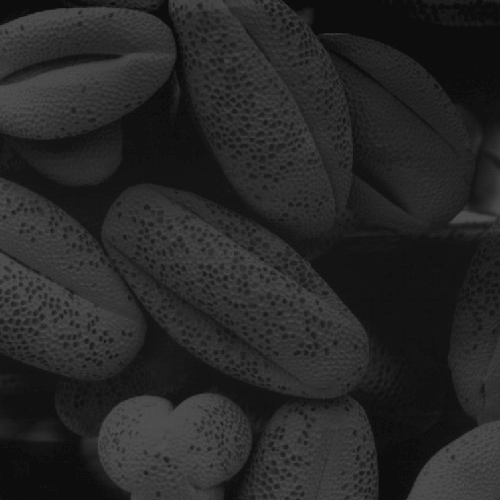

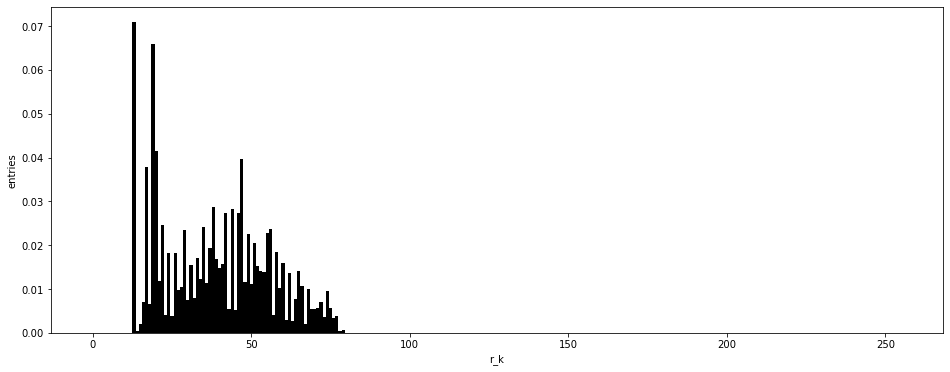

In [8]:
display(img_1)

plot_hist(hist_1)

As one may see, the histogram is heavily biased toward the dark.

Now lets perform equalization with the purpose to make the histogram uniform:

In [9]:
np_1_new = eq_uniform(np_1, hist_1)
hist_1_new = im_hist_np(np_1_new)

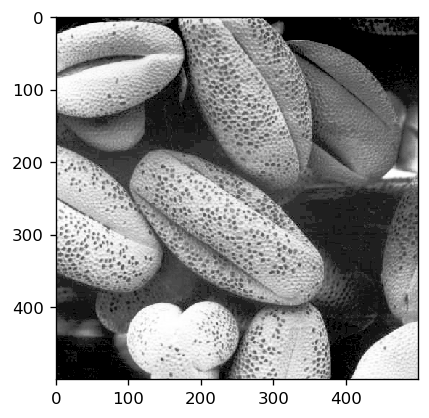

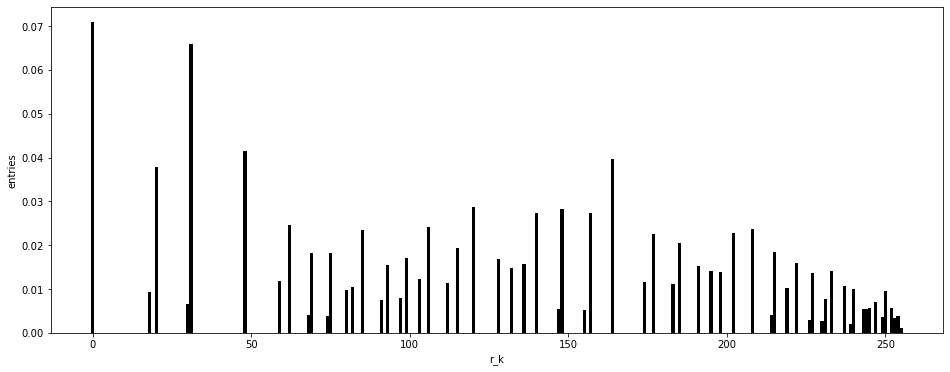

In [10]:
plt.figure(dpi=120)
plt.imshow(np_1_new, cmap='gist_gray')
plt.show()

plot_hist(hist_1_new)

Now the image have more details and looks better overall.

Let's consider the second image:

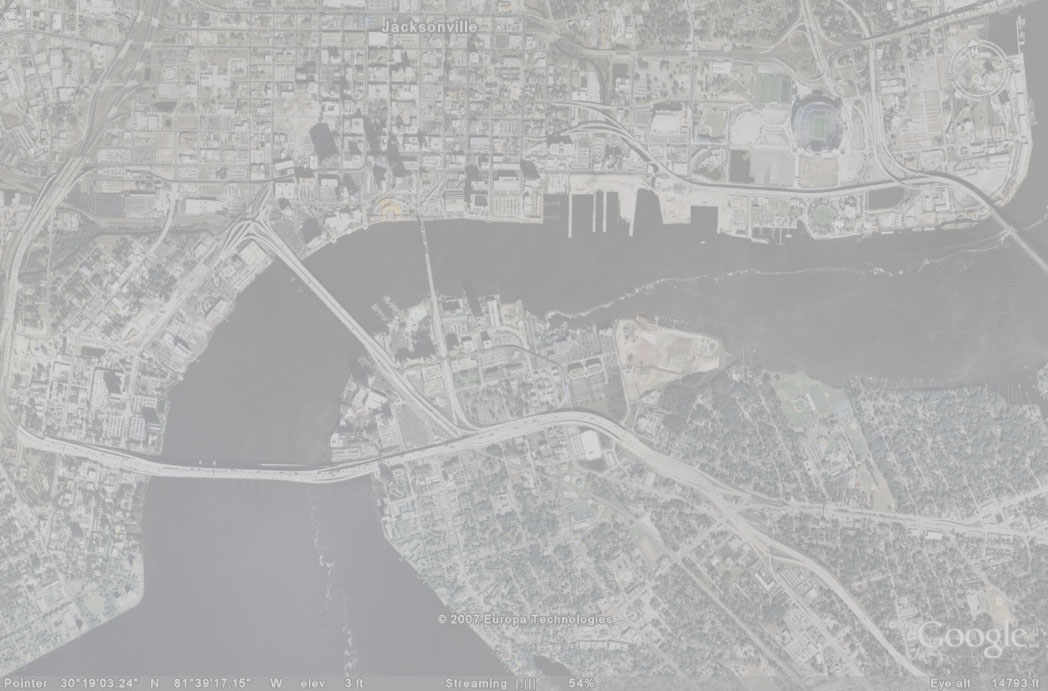

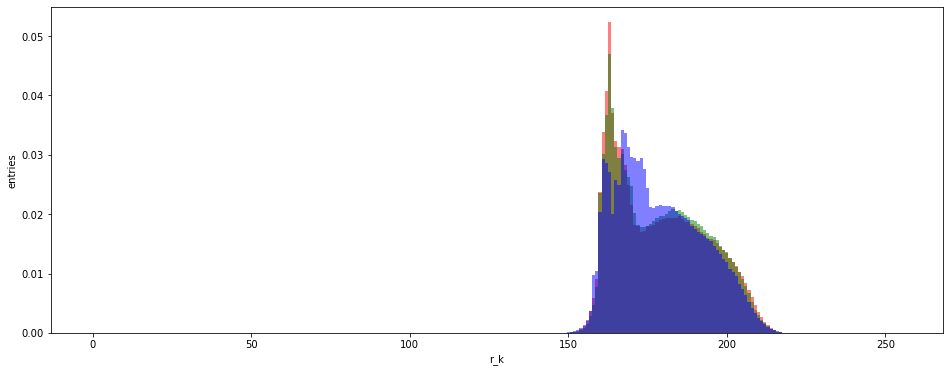

In [11]:
display(img_2)

plot_hist(hist_2)

It is clear that the image is too bright, which prevents us from perceivin it as a decent map.

In [12]:
np_2_new = eq_uniform(np_2, hist_2)
hist_2_new = im_hist_np(np_2_new)

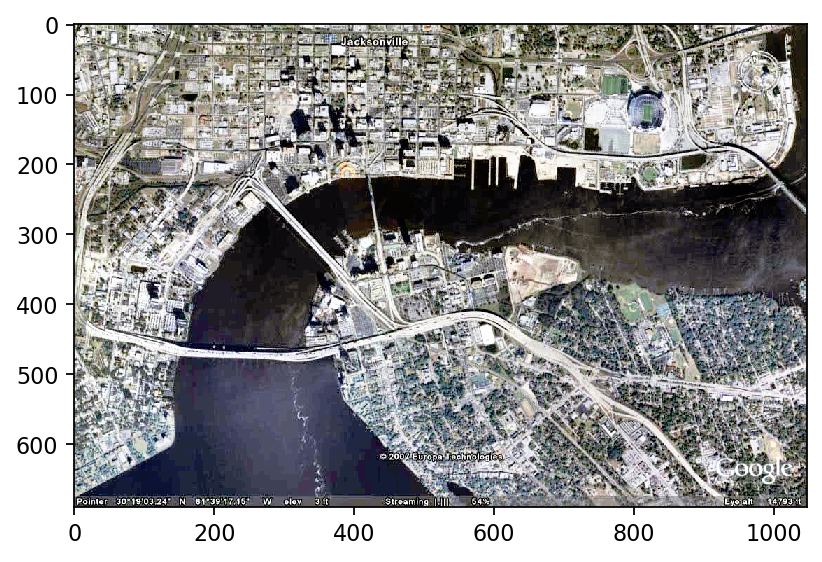

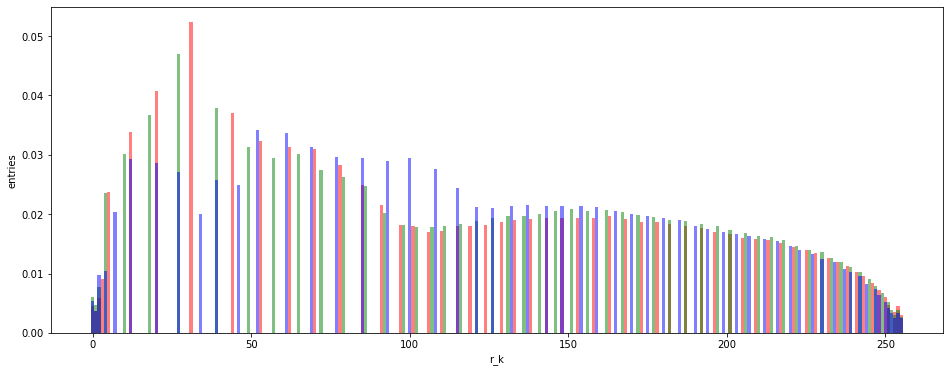

In [13]:
plt.figure(dpi=160)
plt.imshow(np_2_new)
plt.show()

plot_hist(hist_2_new)

The map is now equally bright and dark, as it is supposed to be after equalization.

## Local equalization
### Theory

Sometimes, we need to process an image not as a whole entity, but rather as a collection of features. 
Those features can differ from each other, therefore the usual global equalization technique may appear inappropriate, since it considers the overall information about an image.
Thus, the concept of local equalization takes its place.
The main idea behind this technique is to process each pixel considering only its neighborhood, which is supposed to be small relative to the shape of the whole picture. 

### Code

#### Uniform local equalizer

In [14]:
import numpy as np


def eq_uniform_local(img, ker_size=3):
    h = img.shape[0]
    w = img.shape[1]
    pad_size = (ker_size - 1) // 2
    Lm1 = 256
    coef = Lm1 / (ker_size * ker_size)
    
    img_new = np.zeros_like(img)
    
    if len(img.shape) == 3:
        channels = img.shape[-1]
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size, channels))
        img_padded[pad_size:-pad_size, pad_size:-pad_size, :] = img
        for i in range(h):
            for j in range(w):
                img_loc = img_padded[i:i+ker_size, j:j+ker_size, :]
                for ch in range(channels):
                    img_loc_ch = img_loc[:, :, ch]
                    lower_args = np.argwhere(img_loc_ch < img_loc_ch[pad_size, pad_size])
                    img_new[i, j, ch] = lower_args.shape[0] * coef
    else:
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size))
        img_padded[pad_size:-pad_size, pad_size:-pad_size] = img
        for i in range(h):
            for j in range(w):
                img_loc = img_padded[i:i+ker_size, j:j+ker_size]
                lower_args = np.argwhere(img_loc < img_loc[pad_size, pad_size])
                img_new[i, j] = lower_args.shape[0] * coef
                
    img_new = img_new.astype(np.uint8)
    return img_new

### Results

#### Processing + visualization

Load an image with hidden symbols on it:

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# From R. Gonzales, R. Woods "Digital Image Processing"
img_21 = Image.open('./symb.tif')

In [16]:
# represent the images as tensors
np_21 = np.array(img_21)
print('Picture dimensions:')
print(np_21.shape)

Picture dimensions:
(512, 512)


Process the image both with the global and local (3x3) equalizers:

In [17]:
hist_21 = im_hist_np(np_21)
np_21_glob = eq_uniform(np_21, hist_21)
np_21_loc = eq_uniform_local(np_21, 3)

The results are as shown:

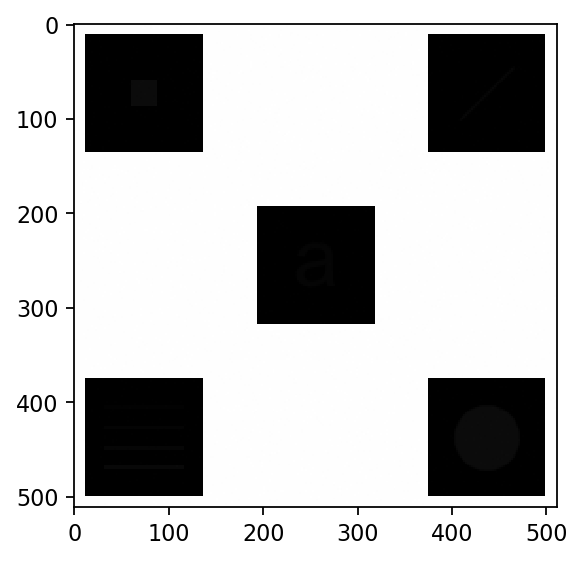

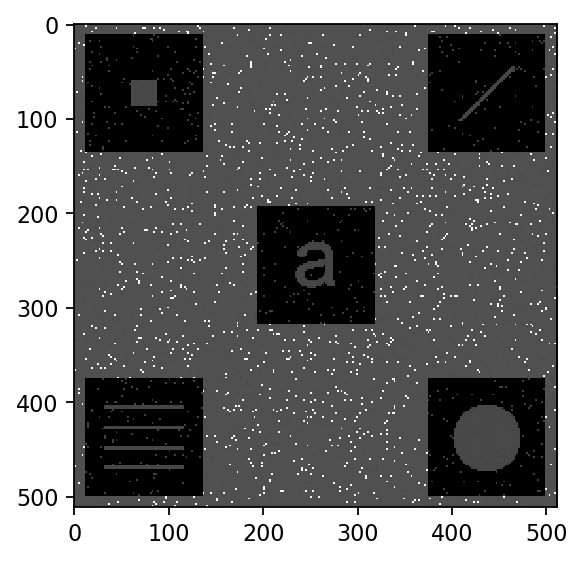

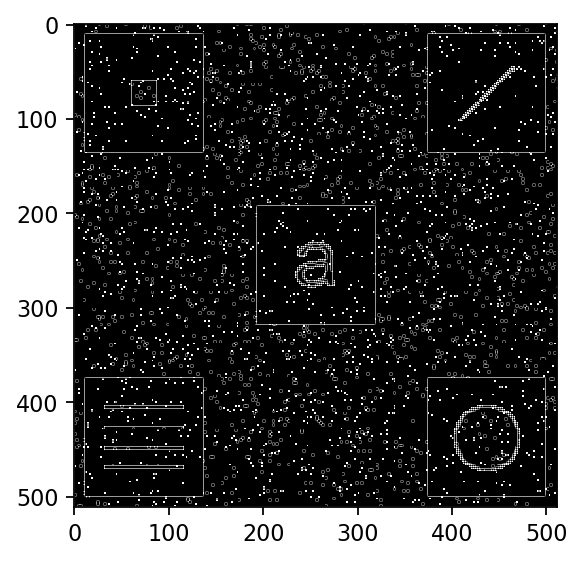

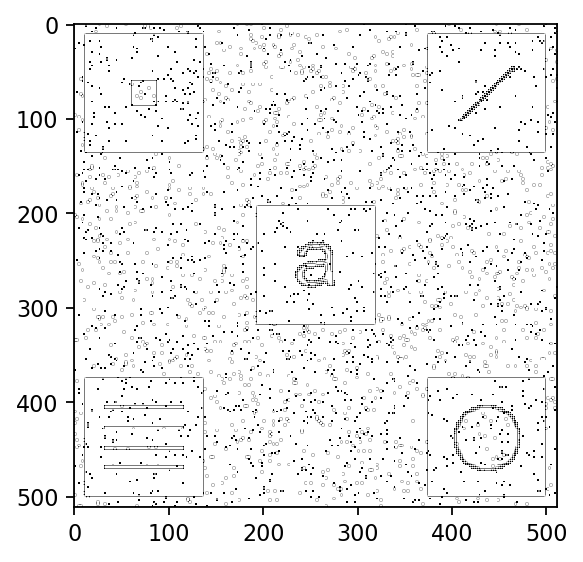

In [18]:
plt.figure(dpi=160)
plt.imshow(np_21, cmap='gray')

plt.figure(dpi=160)
plt.imshow(np_21_glob, cmap='gray')

plt.figure(dpi=160)
plt.imshow(np_21_loc, cmap='gray')

plt.figure(dpi=160)
plt.imshow(np_21_loc, cmap='Greys')

The first image is the original picture, the second one is that processed by the global equalization function. 
The last two picturest are the results of the local equalization: before and after application of the "negative" transformation.
While the global equalization allows to extract the desired features (highlight the figures inside the black squares), the local equalization extracts their borders and distinguish more precisely.